# Kernel Functions Profiling

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# RTApp configurator for generation of PERIODIC tasks
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace

# Target Configuration

In [3]:
# Setup target configuration
androidsdk_path=os.path.join(os.getcwd(), "../../../android-sdk")
my_conf = {

    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : androidsdk_path,
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
#             'ip_address'     : '10.65.34.1',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },  

    # Folder where all the results will be collected
    "results_dir" : "TraceAnalysis_FunctionsProfiling",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "functions" : [
            "pick_next_task_fair",
            "select_task_rq_fair",
            "enqueue_task_fair",
            "update_curr_fair",
            "dequeue_task_fair",
            
            # for tests
            "scheduler_timeout",
            "tick_sched_timer",
            "tick_sched_do_timer",
            "schedtune_cpu_boost",
            "schedtune_task_boost",
            "schedtune_prefer_idle",
            "schedtune_enqueue_task",
            "schedtune_dequeue_task",

        ],
        
         "events" : [
             "sched_load_avg_cpu",
             "sched_load_avg_task",
             "sched_switch",
             "cpu_frequency"
             
         ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    

}

In [4]:
# Initialize a test environment using:
te = TestEnv(my_conf)
target = te.target

03:55:13  INFO    : Using base path: /home/steven/lisa/lisa-github
03:55:13  INFO    : Loading custom (inline) target configuration
03:55:13  WARNING : Wipe previous contents of the results folder:
03:55:13  WARNING :    /home/steven/lisa/lisa-github/results/TraceAnalysis_FunctionsProfiling
03:55:13  INFO    : External tools using:
03:55:13  INFO    :    ANDROID_HOME: /home/steven/lisa/lisa-github/ipynb/workshop/../../../android-sdk
03:55:13  INFO    :    CATAPULT_HOME: /home/steven/lisa/lisa-github/tools/catapult
03:55:13  INFO    : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
03:55:13  INFO    : Connecting Android target [0123456789ABCDEF]
03:55:13  INFO    : Connection settings:
03:55:13  INFO    :    {'device': '0123456789ABCDEF'}
03:55:14  INFO    : Initializing target workdir:
03:55:14  INFO    :    /data/local/tmp/devlib-target
03:55:17  INFO    : Attempting to read energy model from target
03:55:17  INFO    : Topology:
03:55:17  INFO    :    [[0, 1, 2, 3], [4, 5, 6, 7]]

# Workload Execution and Functions Profiling Data Collection

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

03:55:28  INFO    : Setup new workload ramp
03:55:28  INFO    : Workload duration defined by longest task
03:55:28  INFO    : Default policy: SCHED_OTHER
03:55:28  INFO    : ------------------------
03:55:28  INFO    : task [ramp], sched: using default policy
03:55:28  INFO    :  | loops count: 1
03:55:28  INFO    : + phase_000001: duration 0.500000 [s] (5 loops)
03:55:28  INFO    : |  period   100000 [us], duty_cycle  60 %
03:55:28  INFO    : |  run_time  60000 [us], sleep_time  40000 [us]
03:55:28  INFO    : + phase_000002: duration 0.500000 [s] (5 loops)
03:55:28  INFO    : |  period   100000 [us], duty_cycle  55 %
03:55:28  INFO    : |  run_time  55000 [us], sleep_time  45000 [us]
03:55:28  INFO    : + phase_000003: duration 0.500000 [s] (5 loops)
03:55:28  INFO    : |  period   100000 [us], duty_cycle  50 %
03:55:28  INFO    : |  run_time  50000 [us], sleep_time  50000 [us]
03:55:28  INFO    : + phase_000004: duration 0.500000 [s] (5 loops)
03:55:28  INFO    : |  period   100000 [

# Parse Trace and Profiling Data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

03:55:40  INFO    : Content of the output folder /home/steven/lisa/lisa-github/results/TraceAnalysis_FunctionsProfiling


/home/steven/lisa/lisa-github/results/TraceAnalysis_FunctionsProfiling
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── rt-app-ramp_1-2.log
├── rt-app-ramp_1-4.log
├── rt-app-ramp_2-3.log
├── rt-app-ramp_2-5.log
├── trace.dat
└── trace.stats

0 directories, 10 files


In [8]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

03:55:41  INFO    : LITTLE cluster max capacity: 462


In [9]:
my_conf['ftrace']['events']

['sched_load_avg_cpu', 'sched_load_avg_task', 'sched_switch', 'cpu_frequency']

In [10]:
trace = Trace(platform, te.res_dir, events=my_conf['ftrace']['events'])

03:55:43  INFO    : Platform clusters verified to be Frequency coherent


In [11]:
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.SchedContribScaleFactor object at 0x7f4134b9d2d0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.sched.SchedCpuCapacity object at 0x7f412fa41090> from cache, reading it from trace
  warnings.warn(warnstr)
/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.thermal.Thermal object at 0x7f412fa41450> from cache, reading it from trace
  warnings.warn(warnstr)
/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.SchedWakeupNew object at 0x7f412fa41550> from cache, reading it from trace
  warnings.warn(warnstr)
/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.thermal.ThermalGovernor object 

# Report Functions Profiling Data

In [13]:
# Get the DataFrame for the specified list of kernel functions
df = trace.data_frame.functions_stats(['enqueue_task_fair', 'dequeue_task_fair'])
df

hits     avg       time     s_2
0 dequeue_task_fair   798   8.140   6496.363  24.645
  enqueue_task_fair  1421   8.759  12447.400  29.587
1 dequeue_task_fair  1061   7.298   7743.247  13.619
  enqueue_task_fair   578   8.930   5161.981  20.201
2 dequeue_task_fair   271   7.833   2122.915  20.552
  enqueue_task_fair   109   9.136    995.828  28.425
3 dequeue_task_fair    33   9.785    322.916  29.971
  enqueue_task_fair     4  13.021     52.084  51.177
4 dequeue_task_fair   127   2.969    377.080   2.847
  enqueue_task_fair    53   2.574    136.455   2.279
5 dequeue_task_fair    15   3.715     55.726   4.723
  enqueue_task_fair     1   2.083      2.083   0.000
6 dequeue_task_fair    13   1.522     19.793   0.337
  enqueue_task_fair     5   2.083     10.417   0.678

In [14]:
# Get the DataFrame for the single specified kernel function
df = trace.data_frame.functions_stats('select_task_rq_fair')
df

,,hits,avg,time,s_2
0,select_task_rq_fair,1347,8.916,12010.940,10.153
1,select_task_rq_fair,539,5.763,3106.764,23.206
2,select_task_rq_fair,105,3.660,384.370,18.187
3,select_task_rq_fair,4,5.989,23.958,30.833
4,select_task_rq_fair,16,3.287,52.602,3.498
5,select_task_rq_fair,1,4.687,4.687,0.000
6,select_task_rq_fair,4,2.083,8.333,1.264


# Plot Functions Profiling Data

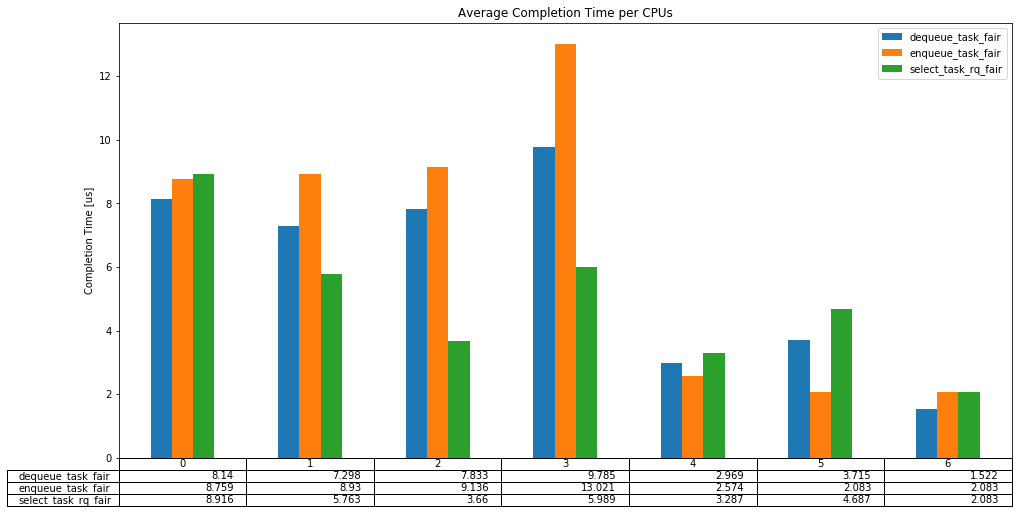

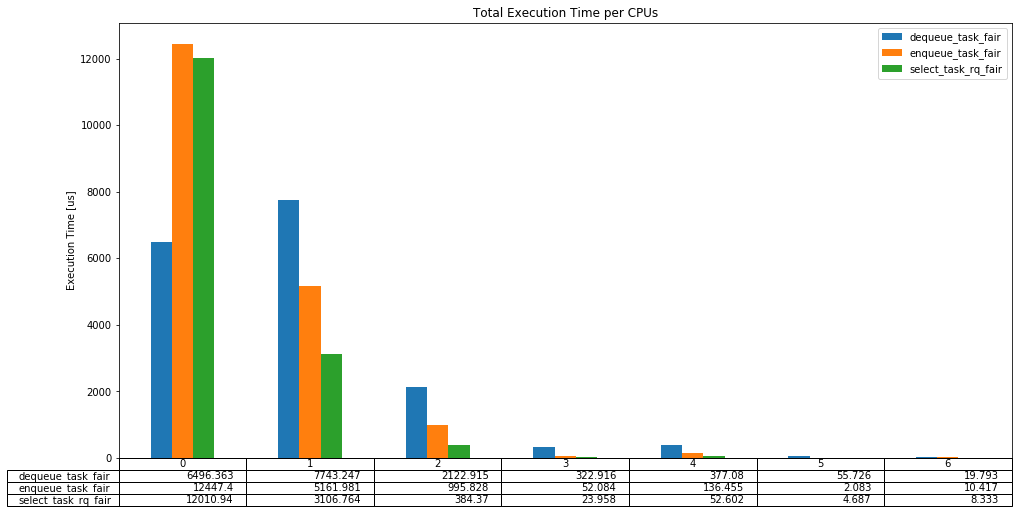

In [15]:
# Plot Average and Total execution time for the specified
# list of kernel functions
trace.analysis.functions.plotProfilingStats(
    functions = [
        'select_task_rq_fair',
        'enqueue_task_fair',
        'dequeue_task_fair'
    ],
    metrics = [
        'avg',
        'time',
    ]
)

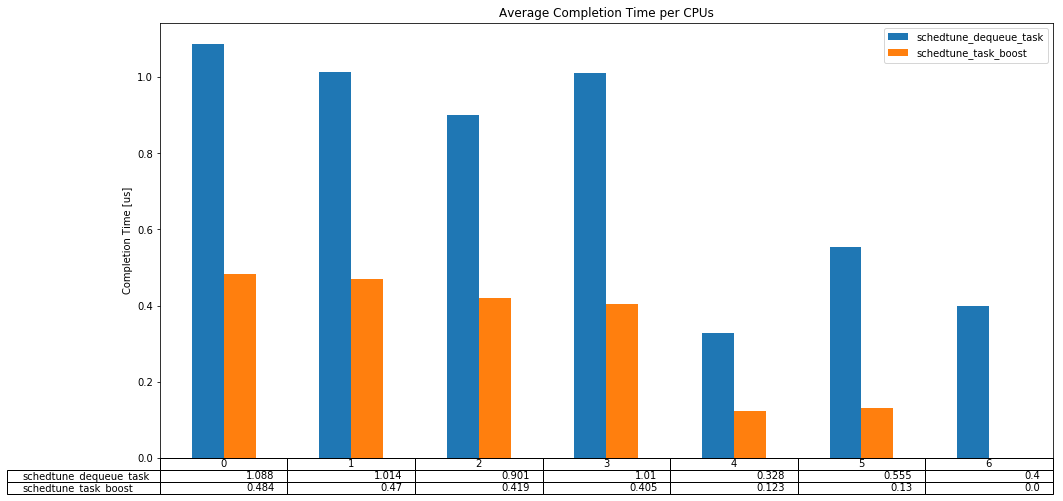

In [16]:
# Plot Average execution time for the single specified kernel function
trace.analysis.functions.plotProfilingStats(
    functions = [
            "scheduler_timeout",
            "schedtune_dequeue_task",
            "schedtune_task_boost",        
                ]
)